# 16.4 AutoRec: Rating Prediction with Autoencoders

https://d2l.ai/chapter_recommender-systems/autorec.html

In [19]:
from d2l import torch as d2l
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from surprise import Dataset
from sklearn.model_selection import train_test_split
from scipy import sparse

## Dataset/DataLoader

In [21]:
data = Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()
n_users = trainset.n_users
n_items = trainset.n_items

trainset = [el for el in trainset.all_ratings()]
trainset = list(trainset)
trainset, testset = train_test_split(trainset, test_size=0.2)

n_users, n_items

(943, 1682)

In [37]:
class MLDataset(Dataset):
    def __init__(self, data, n_users, n_items):
        self.data = data
        I, J, V = tuple(zip(*data))
        self.R = sparse.coo_matrix((V, (I, J)), shape=(n_users, n_items)).tocsr()
        self.R = torch.from_numpy(self.R.toarray()).float()
        
    def __len__(self):
        return self.R.shape[1]
    
    def __getitem__(self, item_index):
        return self.R[:, item_index]

In [38]:
train_dl = DataLoader(
    MLDataset(trainset, n_users, n_items), shuffle=True, batch_size=256, pin_memory=True
)
test_dl = DataLoader(
    MLDataset(testset, n_users, n_items), shuffle=False, batch_size=256, pin_memory=True
)

## Model

In [43]:
class AutoRec(nn.Module):
    def __init__(self, num_hidden, num_users, dropout=0.5):
        super().__init__()
        self.encoder = nn.Linear(num_users, num_hidden)
        self.decoder = nn.Linear(num_hidden, num_users)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, users_item):
        hat_users_item = torch.sigmoid(self.encoder(users_item))
        hat_users_item = self.dropout(hat_users_item)
        hat_users_item = self.decoder(hat_users_item)
        hat_users_item = (
            hat_users_item * torch.sign(users_item)  # we don't care for the unknown ratings
            if self.training else hat_users_item)
        return hat_users_item

## Training and Evaluating the model

In [67]:
def evaluator(train_dl, test_dl, net):
    dl = train_dl if net.training else test_dl
    
    running_loss = 0
    supports = 0
    for k, R_i in enumerate(dl):
        if net.training:
            optimizer.zero_grad()
        hat_R_i = net(R_i)
        if not net.training:
            hat_R_i = hat_R_i * torch.sign(R_i)
        loss = criterion(hat_R_i, R_i)
        if net.training:
            loss.backward()
            optimizer.step()
        running_loss += loss.item()
        supports += torch.sign(R_i).sum().item()
            
    return running_loss / supports

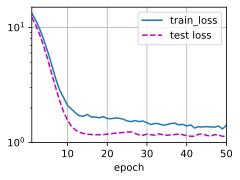

In [72]:
epochs = 50

net = AutoRec(30, n_users, dropout=0.5)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(
    net.parameters(), lr=0.002, weight_decay=0.0)

animator = d2l.Animator(
    xlabel='epoch', xlim=[1, epochs],
    yscale='log',
    legend=['train_loss', 'test loss']
)

for epoch in range(1, epochs + 1):
    net.train()
    train_loss = evaluator(train_dl, test_dl, net)
    net.eval()
    test_loss = evaluator(train_dl, test_dl, net)
    animator.add(epoch, (train_loss, test_loss))